In [1]:
from ipywidgets import widgets
from IPython.display import display, display_svg, clear_output
from globus_automate_client import create_flows_client, graphviz_format, state_colors_for_log
import json
import time

CLIENT_ID = "e6c75d97-532a-4c88-b031-8584a319fa3e"
fc = create_flows_client(CLIENT_ID)

In [2]:
flows_resp = fc.list_flows()
for flow in flows_resp.data['flows']:
    print(f'Flow id: {flow["id"]}, Flow title: {flow["title"]}')
flows = {flow['id']:flow['title'] for flow in flows_resp.data['flows']}

Flow id: 202869e4-d523-45ad-a1e6-c229a4e0dbb5, Flow title: Two Step Transfer Flow
Flow id: 24bc4997-b483-4c25-a19c-64b0afc00743, Flow title: Multi Step Transfer
Flow id: 3fb4c85b-c369-4012-b694-9c4a95b134d3, Flow title: Two Step Transfer Flow
Flow id: 6ec38d49-30ca-4761-beea-201dbbe2d221, Flow title: Scope Problem Flow
Flow id: 6f2322f7-2ae1-401c-8d47-2b7c9f2d2def, Flow title: Run the Hello World Action Provider
Flow id: 923ee9f5-822f-4982-b461-2f932abe947b, Flow title: Testing for timeout handling
Flow id: 95b5bba0-6501-4e4a-af7d-6601bd5a15bd, Flow title: Transfer Move
Flow id: ac1813e7-9abd-42a4-a73b-633509d93903, Flow title: Hello World Test
Flow id: c394ecda-c510-4f08-9096-aca7790282a5, Flow title: Two Step Transfer Flow


In [3]:
# Select an id from one of the flows above to continue exploring and running
flow_id = 'c394ecda-c510-4f08-9096-aca7790282a5'

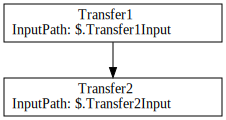

In [4]:
get_resp = fc.get_flow(flow_id)
flow_def = get_resp.data['definition']
flow_graph = graphviz_format(flow_def)
display(flow_graph)

In [5]:

text = widgets.Textarea(placeholder='Enter JSON formatted input for to the Flow', 
                        layout={'height': '100%', 'width': '500px'})
button = widgets.Button(description='Click to Run Flow')
items = [text, button]
box = widgets.HBox(items, layout={'height': '300px'})
display(box)
action_id = ''

def on_input(sender):
    input_val = text.value
    flow_input = json.loads(input_val)
    run_resp = fc.run_flow(flow_id, None, flow_input)
    global action_id
    action_id = run_resp.data['action_id']
    print(f'action_id: {action_id}')
    
button.on_click(on_input)

In [ ]:
while(True):
    status_resp  = fc.flow_action_status(flow_id, None, action_id)
    log_resp = fc.flow_action_log(flow_id, None, action_id, limit=100)
    state_colors = state_colors_for_log(log_resp.data['entries'])
    run_graph = graphviz_format(flow_def, state_colors)
    print(f'Action {action_id} is in state {status_resp.data["status"]} at time {time.ctime()}')
    display(run_graph)
    if status_resp.data['status'] in ('SUCCEEDED'):
        break
    time.sleep(5)
    clear_output(wait=True)